In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros


In [35]:
def analisis_armonicos_cilindricos_laser(
    R=300e-6,
    sigma=0.5,
    m=4,
    N=2000,
    n_modos=20,
    plot=True
):
    """
    Análisis de armónicos cilíndricos (modos J0) de un haz láser supergaussiano.

    I(r) = exp[-(r/sigma)^m]

    Calcula la amplitud física de cada modo cilíndrico n,
    adecuada para compararse directamente con σ_RT(k_n).

    Retorna
    -------
    k_n : ndarray
        Números de onda cilíndricos
    A_n : ndarray
        Amplitud normalizada de cada modo cilíndrico
    n_values : ndarray
        Índices de modo (empezando en 1)
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.special import j0, jn_zeros

    # ==================================================
    # 1. Dominio radial
    # ==================================================
    r = np.linspace(0, R, N)

    # ==================================================
    # 2. Perfil láser supergaussiano
    # ==================================================
    I = np.exp(-(r / sigma)**m)

    # ==================================================
    # 3. Modos cilíndricos (J0)
    # ==================================================
    zeros = jn_zeros(0, n_modos)
    k_n = zeros / R
    n_values = np.arange(1, n_modos + 1)  # Modos indexados desde 1

    # ==================================================
    # 4. Proyección modal (ORTONORMAL)
    # ==================================================
    A_n = np.zeros(n_modos)

    for i in range(n_modos):
        Jn = j0(k_n[i] * r)

        # Proyección radial correcta (peso r)
        numerador = np.trapz(I * Jn * r, r)
        denominador = np.trapz(Jn**2 * r, r)

        A_n[i] = numerador / (denominador + 1e-15)

    # ==================================================
    # 5. Normalización energética
    # ==================================================
    A_n = np.abs(A_n)
    A_n /= np.max(A_n)

    # ==================================================
    # 6. Plots mejorados
    # ==================================================
    if plot:
        # --- Perfil láser ---
        plt.figure(figsize=(6,4))
        plt.plot(r*1e6, I, color='blue', lw=2)
        plt.xlabel("r [μm]", fontsize=12)
        plt.ylabel(r"$I(r)/I_0$", fontsize=12)
        plt.title("Perfil radial del láser (supergaussiano)", fontsize=14)
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

        # --- Espectro modal ---
        plt.figure(figsize=(8,4))
        plt.bar(n_values, A_n, width=0.6, color='orange', edgecolor='black', alpha=0.8)
        plt.yscale("log")
        plt.xlabel("Modo cilíndrico n", fontsize=12)
        plt.ylabel(r"Amplitud normalizada $a_n$", fontsize=12)
        plt.title("Espectro de modos cilíndricos del láser", fontsize=14)

        # --- Ajuste de ticks en el eje x de 1, 10, 20, 30 ... ---
        max_tick = int(np.ceil(n_modos / 10) * 10)
        xticks = np.arange(1, max_tick+1, 10)
        plt.xticks(xticks)

        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    return k_n, A_n, n_values





In [32]:
def amplitud_modos_plasma_vs_laser_subplots(
    ruta_hdf5,
    indice_propiedad,
    k_n_laser,
    A_laser,
    iz0,
    iz1,
    tiempos_ns,
    R=300e-6
):
    """
    Muestra la proyección de la propiedad del plasma en los modos del láser
    para varios instantes temporales en una sola figura con subplots.

    Cada subplot corresponde a un tiempo de tiempos_ns.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt
    from scipy.special import j0
    from scipy.interpolate import interp1d

    # -----------------------------
    # Propiedad
    # -----------------------------
    propiedades = {
        0: "lower x edge [m]",
        1: "upper x edge [m]",
        2: "lower y edge [m]",
        3: "upper y edge [m]",
        4: "cell volume [m3]",
        5: "density [kg/m3]",
        6: "velocity x [m/s]",
        7: "velocity y [m/s]",
        8: "temperature [eV]",
        9: "SDE [W/m3]",
        10: "P_therm [Pa]",
        11: "P_rad [Pa]",
        12: "P_total [Pa]",
        13: "internal energy [J/kg]",
        14: "cv [J/kg/K]",
        15: "rho*cv [J/m3/K]",
        16: "sound speed [m/s]",
        17: "charge state",
        18: "electron density [e/m3]",
        19: "kinetic energy"
    }
    nombre_prop = propiedades.get(indice_propiedad, f"propiedad {indice_propiedad}")

    # -----------------------------
    # Cargar propiedad
    # -----------------------------
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    ruta_npy = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")

    if not os.path.exists(ruta_npy):
        raise FileNotFoundError("Debe ejecutar extraer_propiedad primero.")

    data = np.load(ruta_npy, mmap_mode="r")  # (Nt, Nz, Nr)
    Nt, Nz, Nr = data.shape

    # -----------------------------
    # Tiempos reales
    # -----------------------------
    tiempos_h5 = []
    with h5py.File(ruta_hdf5, "r") as f:
        for _, obj in f.items():
            if isinstance(obj, h5py.Dataset) and "time" in obj.attrs:
                tiempos_h5.append(float(obj.attrs["time"][0]))
    tiempos_h5 = np.array(tiempos_h5)
    if len(tiempos_h5) != Nt:
        tiempos_h5 = np.linspace(0, Nt-1, Nt)

    tiempos_ns_reales = tiempos_h5 * 1e9

    # -----------------------------
    # Dominio radial y modos
    # -----------------------------
    r = np.linspace(0, R, Nr)
    modos = np.arange(1, len(k_n_laser)+1)

    # -----------------------------
    # Interpolación y cálculo
    # -----------------------------
    A_all = []

    for t_ns in tiempos_ns:
        # Interpolar el perfil radial sobre el tiempo deseado
        f_interp = interp1d(tiempos_ns_reales, np.mean(data[:, iz0:iz1+1, :], axis=1),
                            axis=0, kind="linear", fill_value="extrapolate")
        perfil_r = f_interp(t_ns)

        # Proyección sobre los modos del láser
        A_t = np.array([
            np.abs(np.trapz(perfil_r * j0(k*r) * r, r) / np.trapz((j0(k*r))**2 * r, r))
            for k in k_n_laser
        ])
        A_t /= A_t.max()
        A_all.append(A_t)

    A_all = np.array(A_all)

    # -----------------------------
    # PLOTS en subplots
    # -----------------------------
    n_tiempos = len(tiempos_ns)
    fig, axes = plt.subplots(1, n_tiempos, figsize=(6*n_tiempos, 5), squeeze=False)

    for ax, A_t, t_ns in zip(axes[0], A_all, tiempos_ns):
        # Fondo: láser
        ax.bar(modos, A_laser, width=0.8, color="lightgray",
               edgecolor="black", alpha=0.6, label="Modos del láser")

        # Plasma: curva
        ax.plot(modos, A_t, lw=2, marker="o", label=f"Plasma t = {t_ns:.3f} ns")

        ax.set_yscale("log")
        ax.set_xlabel("Modo cilíndrico n")
        ax.set_ylabel("Amplitud normalizada")
        ax.set_title(f"t = {t_ns:.3f} ns")
        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.set_xticks(np.arange(1, len(k_n_laser)+1, 10))  # ticks de 10 en 10

    fig.suptitle(f"Proyección de {nombre_prop} en modos del láser", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    return A_all, np.array(tiempos_ns)


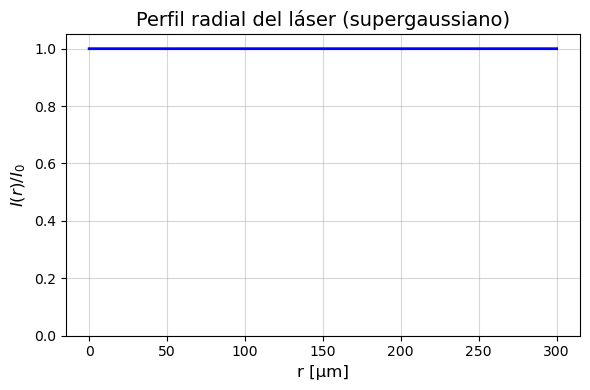

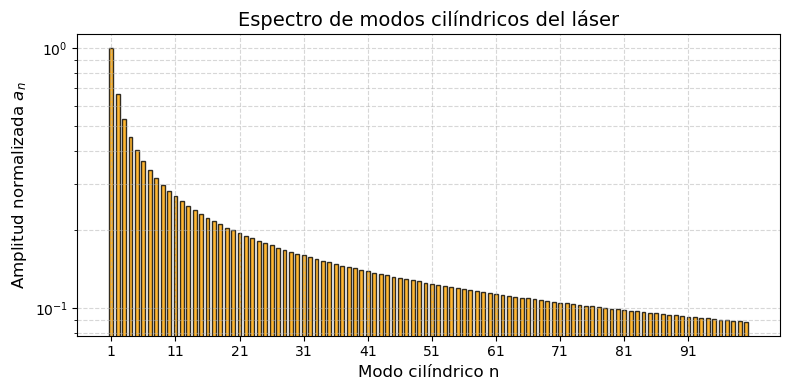

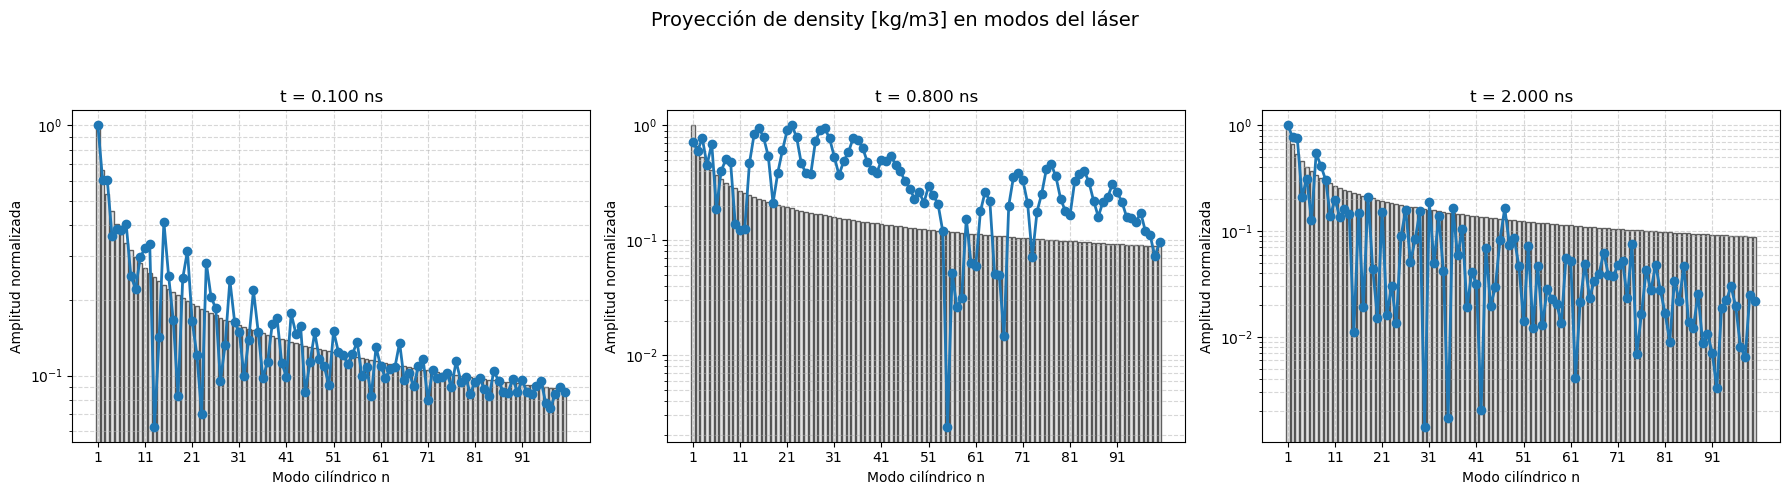

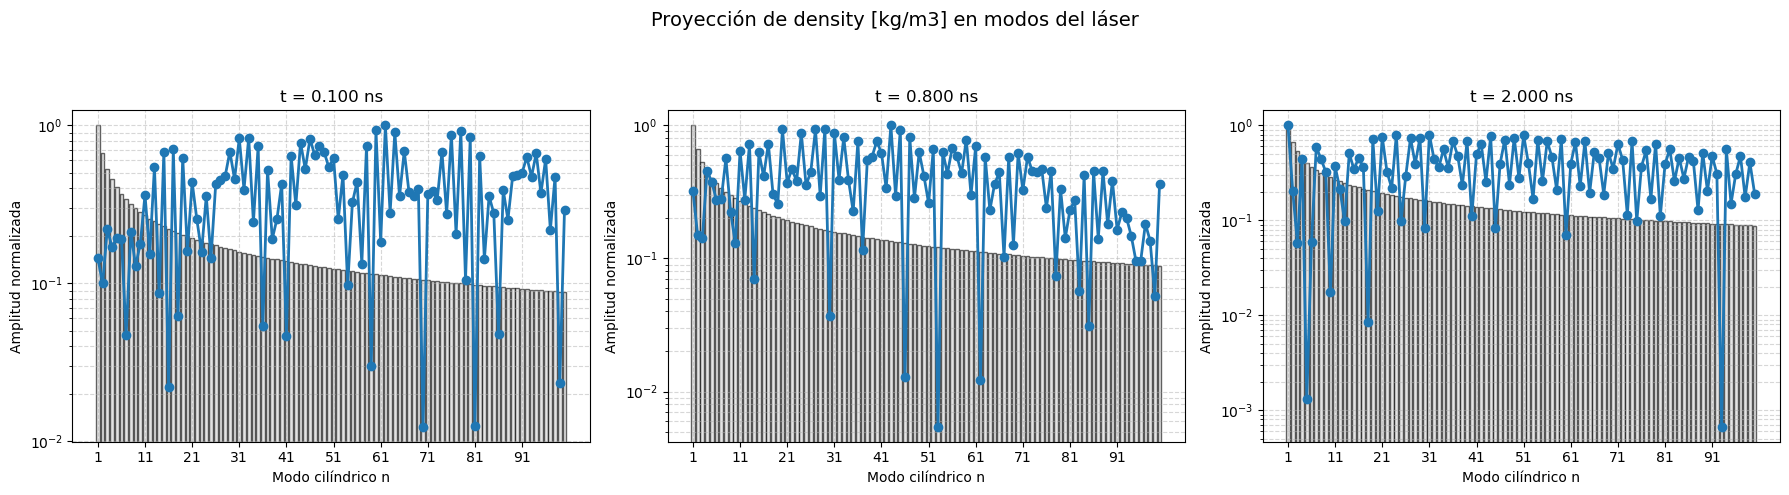

In [43]:
# LD

tiempos_ns_LD = [ 0.02, 0.15, 0.5]
tiempos_ns_HD = [0.1, 0.8, 2]

indice= 5


ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD.h5", r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HD.h5"]

k_n_laser, A_laser, _ = analisis_armonicos_cilindricos_laser(
    R=300e-6,
    sigma=0.5,
    m=4,
    n_modos=100
)

for r in ruta_hdf5:

    A_plasma, tiempos_mostrados = amplitud_modos_plasma_vs_laser_subplots(
        r,
        indice,
        k_n_laser,
        A_laser,
        iz0=480,
        iz1=550,
        tiempos_ns = tiempos_ns_HD
    )

